## Running a bell circuit on different backends

In [2]:
!pip show amazon-braket-sdk

Name: amazon-braket-sdk
Version: 1.72.1
Summary: An open source library for interacting with quantum computing devices on Amazon Braket
Home-page: https://github.com/amazon-braket/amazon-braket-sdk-python
Author: Amazon Web Services
Author-email: 
License: Apache License 2.0
Location: /Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages
Requires: amazon-braket-default-simulator, amazon-braket-schemas, backoff, boltons, boto3, cloudpickle, nest-asyncio, networkx, numpy, openpulse, openqasm3, oqpy, setuptools, sympy
Required-by: pytket-braket, qiskit-braket-provider


In [1]:
import numpy as np
import time

from braket.circuits import Circuit
from braket.devices import LocalSimulator
from qiskit_braket_provider import AWSBraketProvider
from qiskit_braket_provider.providers import adapter
from braket.aws import AwsSession

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BackendEstimator, Estimator
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.primitives import BackendEstimator
from qiskit.circuit import ParameterVector, Parameter

import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)

from braket_estimator import BraketEstimator

aws_session = AwsSession(default_bucket="amazon-braket-us-west-1-lukasvoss")
AWSBraketProvider().backends()

[BraketBackend[Aria 1],
 BraketBackend[Aria 2],
 BraketBackend[Aspen-M-3],
 BraketBackend[Forte 1],
 BraketBackend[Harmony],
 BraketBackend[Lucy],
 BraketBackend[SV1],
 BraketBackend[dm1]]

In [2]:
batchsize = 50
n_shots = 10_000

#### Run with native Braket SV Backend

In [3]:
backend = AWSBraketProvider().get_backend('SV1')

device = backend._device
device

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)

In [4]:
braket_bell_circ = Circuit().h(0).cnot(0, 1)
print(braket_bell_circ)

T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1|


In [5]:
start_time = time.time()
job_braket_native = device.run_batch(
    [braket_bell_circ] * batchsize,
    shots=n_shots,
)
run_batch_time = time.time() - start_time
print('--- {} seconds ---'.format(round(run_batch_time, 2)))
print('Execution time per circuit:', round(run_batch_time / batchsize, 2), 'seconds')

--- 24.22 seconds ---
Execution time per circuit: 0.48 seconds


#### Run with Braket Provider + **Estimator Primitive**

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


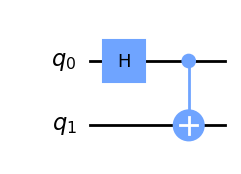

In [6]:
qiskit_bell_circ = QuantumCircuit(2)
qiskit_bell_circ.h(0)
qiskit_bell_circ.cx(0, 1)

qiskit_bell_circ.draw("mpl")

Formerly took 532 secs to complete

In [7]:
backend = AWSBraketProvider().get_backend('SV1')
estimator = BackendEstimator(backend)
qiskit_observables = SparsePauliOp.from_list(([('XX', 0.25), ("IZ", 0.25), ("ZZ", 0.25), ("XY", 0.25)]))

qiskit_start_time = time.time()
job = estimator.run(
    circuits=[qiskit_bell_circ] * batchsize,
    observables=[qiskit_observables] * batchsize,
    shots=n_shots
)
job.result().values # This is the time-consuming line

qiskit_run_batch_time = time.time() - qiskit_start_time
print('--- {} seconds ---'.format(round(qiskit_run_batch_time, 2)))
print('Execution time per circuit:', round(qiskit_run_batch_time / (batchsize * 3), 2), 'seconds')

I0000 00:00:1709450208.701507       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:475: UserWarning: Device does not support global phase; global phase of 1.5707963267948966 will not be included in Braket circuit
  warnings.warn(
/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:475: UserWarning: Device does not support global phase; global phase of 2.3561944901923457 will not be included in Braket circuit
  warnings.warn(
/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:475: UserWarning: Device does not support global phase; global phase of 4.71238898038469 will not be included in Braket circuit
  warnings.warn(


--- 988.75 seconds ---
Execution time per circuit: 6.59 seconds


In [8]:
qiskit_expvals = job.result().values

#### Use ``Estimator`` from Qiskit

In [9]:
start_time = time.time()
job = Estimator().run(
    circuits=[qiskit_bell_circ] * batchsize,
    observables=[qiskit_observables] * batchsize,
    shots=n_shots
)
qiskit_expvals_2 = job.result().values
run_batch_time = time.time() - start_time
print('--- {} seconds ---'.format(round(run_batch_time, 2)))
# Three non-commuting parts of the Hamiltonian lead to three measured circuits per Hamiltonian
print('Execution time per circuit:', round(run_batch_time / (batchsize * 3), 2), 'seconds')

--- 0.03 seconds ---
Execution time per circuit: 0.0 seconds


In [10]:
qiskit_expvals_2 - qiskit_expvals

array([ 0.00016161,  0.00358023, -0.00255551,  0.00491985,  0.00400244,
       -0.0002622 ,  0.00053505,  0.00290151,  0.00057174,  0.00555233,
        0.00183546,  0.00056526, -0.00361244, -0.00052993, -0.00459969,
       -0.00127279, -0.00189426, -0.00431203,  0.01369667, -0.00973266,
        0.00063961,  0.00187942, -0.00651264,  0.00535101,  0.00448897,
       -0.0084201 ,  0.00042543,  0.00141005, -0.00016355,  0.00480554,
        0.00182727,  0.0048105 , -0.00499586, -0.00218026, -0.00495539,
        0.00674686,  0.00413243,  0.00074122, -0.0047872 ,  0.00890319,
       -0.00308411, -0.00607406,  0.0026444 , -0.0093078 , -0.00191608,
        0.00539644,  0.00210285,  0.00996703,  0.00131701,  0.01625742])

In [11]:
max(qiskit_expvals_2 - qiskit_expvals)

0.01625742095246796

#### Run Circuit and Measure observables on own ``BraketEstimator``

In [12]:
backend = LocalSimulator()
estimator = BraketEstimator(backend)

braket_observables = qiskit_observables.to_list()

In [13]:
start_time = time.time()
expvals = estimator.run(
    circuit=[braket_bell_circ] * batchsize,
    observables=[braket_observables] * batchsize,
    target_register=[[0, 1]] * batchsize,
    shots=n_shots
)
run_braket_estimator_time = time.time() - start_time
print('--- {} seconds ---'.format(round(run_braket_estimator_time, 2)))
print('Execution time per circuit:', round(run_braket_estimator_time / (batchsize * 3), 2), 'seconds')

--- 5.24 seconds ---
Execution time per circuit: 0.03 seconds


In [14]:
expvals.astype(float) - qiskit_expvals

/var/folders/6b/76tj41f506g7_0dg_k15w_d80000gn/T/ipykernel_6231/798129361.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  expvals.astype(float) - qiskit_expvals


array([-0.00085, -0.0061 , -0.0008 , -0.00075,  0.00175, -0.0062 ,
        0.00635, -0.00325, -0.0022 ,  0.0014 ,  0.0004 ,  0.0002 ,
        0.002  ,  0.00785, -0.0018 , -0.00235,  0.00135,  0.0034 ,
        0.00575, -0.0035 ,  0.00225, -0.00175, -0.0064 ,  0.0004 ,
       -0.00055, -0.0037 ,  0.00765,  0.00055,  0.00115, -0.00265,
       -0.0011 ,  0.0009 ,  0.0026 ,  0.0043 , -0.0035 ,  0.00625,
        0.0024 , -0.00345, -0.00285,  0.0023 , -0.0037 , -0.0103 ,
        0.00225, -0.00835, -0.00865, -0.00045, -0.0019 ,  0.00605,
       -0.0017 ,  0.00705])

In [15]:
max(expvals.astype(float) - qiskit_expvals)

/var/folders/6b/76tj41f506g7_0dg_k15w_d80000gn/T/ipykernel_6231/3208180139.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  max(expvals.astype(float) - qiskit_expvals)


0.007849999999999968

#### Running batch of qiskit circuits with SV1 backend provider

In [16]:
backend = AWSBraketProvider().get_backend('SV1')

In [17]:
qiskit_start_time = time.time()
job = backend.run(
    [qiskit_bell_circ] * batchsize,
    shots=n_shots
)
result = job.result() # This is the time-consuming line

qiskit_run_batch_time = time.time() - qiskit_start_time
print('--- {} seconds ---'.format(round(qiskit_run_batch_time, 2)))
print('Execution time per batch:', round(qiskit_run_batch_time / batchsize, 2), 'seconds')

--- 164.2 seconds ---
Execution time per batch: 3.28 seconds
